<a href="https://colab.research.google.com/github/aksoftwaredev/project-0/blob/main/Res_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import gc
import cv2
import time
import tqdm
import random
import collections
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from functools import partial
import matplotlib.pyplot as plt
from tqdm.auto import tqdm as tq
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import tqdm

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import glob

# ablumentations for easy image augmentation for input as well as output
import albumentations as albu
# from albumentations import torch as AT
plt.style.use('bmh')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip '/content/drive/MyDrive/Brain_tumor_segmentation.zip' -d './Data'

Archive:  /content/drive/MyDrive/Brain_tumor_segmentation.zip
   creating: ./Data/data/
  inflating: ./Data/data/Y1.jpg      
  inflating: ./Data/data/Y1.png      
  inflating: ./Data/data/Y10.jpg     
  inflating: ./Data/data/Y10.png     
  inflating: ./Data/data/Y100.jpg    
  inflating: ./Data/data/Y100.png    
  inflating: ./Data/data/Y101.jpg    
  inflating: ./Data/data/Y101.png    
  inflating: ./Data/data/Y102.jpg    
  inflating: ./Data/data/Y102.png    
  inflating: ./Data/data/Y103.jpg    
  inflating: ./Data/data/Y103.png    
  inflating: ./Data/data/Y104.jpg    
  inflating: ./Data/data/Y104.png    
  inflating: ./Data/data/Y105.jpg    
  inflating: ./Data/data/Y105.png    
  inflating: ./Data/data/Y106.jpg    
  inflating: ./Data/data/Y106.png    
  inflating: ./Data/data/Y107.jpg    
  inflating: ./Data/data/Y107.png    
  inflating: ./Data/data/Y108.jpg    
  inflating: ./Data/data/Y108.png    
  inflating: ./Data/data/Y109.jpg    
  inflating: ./Data/data/Y109.png    


In [5]:
images_path = sorted(glob.glob("./Data/data/*.jpg"))
labels_path = sorted(glob.glob("./Data/data/*.png"))

In [6]:
print(len(images_path))
print(len(labels_path))
print(images_path[18])
print(labels_path[18])

148
148
./Data/data/Y116.jpg
./Data/data/Y116.png


In [7]:
class CustomDataset(Dataset):
  def __init__(self, imagePaths, maskPaths, transforms):
    self.imagePaths = imagePaths
    self.maskPaths = maskPaths
    self.transforms = transforms
  def __len__(self):
    return len(self.imagePaths)
  def __getitem__(self, idx):
    imagePath = self.imagePaths[idx]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(self.maskPaths[idx], 0)
    if self.transforms is not None:
      image = self.transforms(image)
      mask = self.transforms(mask)
    return (image, mask)

In [8]:
imagePaths = images_path
maskPaths = labels_path
split = train_test_split(imagePaths, maskPaths,test_size=0.2, shuffle=True)
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]

print(testImages)
print(testMasks)

['./Data/data/Y153.jpg', './Data/data/Y65.jpg', './Data/data/Y62.jpg', './Data/data/Y33.jpg', './Data/data/Y165.jpg', './Data/data/Y16.jpg', './Data/data/Y74.jpg', './Data/data/Y195.jpg', './Data/data/Y257.jpg', './Data/data/Y10.jpg', './Data/data/Y9.jpg', './Data/data/Y61.jpg', './Data/data/Y160.jpg', './Data/data/Y253.jpg', './Data/data/Y243.jpg', './Data/data/Y17.jpg', './Data/data/Y256.jpg', './Data/data/Y250.jpg', './Data/data/Y194.jpg', './Data/data/Y162.jpg', './Data/data/Y21.jpg', './Data/data/Y22.jpg', './Data/data/Y98.jpg', './Data/data/Y154.jpg', './Data/data/Y52.jpg', './Data/data/Y76.jpg', './Data/data/Y113.jpg', './Data/data/Y120.jpg', './Data/data/Y89.jpg', './Data/data/Y41.jpg']
['./Data/data/Y153.png', './Data/data/Y65.png', './Data/data/Y62.png', './Data/data/Y33.png', './Data/data/Y165.png', './Data/data/Y16.png', './Data/data/Y74.png', './Data/data/Y195.png', './Data/data/Y257.png', './Data/data/Y10.png', './Data/data/Y9.png', './Data/data/Y61.png', './Data/data/Y16

In [9]:
# define transformations
import torchvision.transforms as transforms
transforms = transforms.Compose([transforms.ToPILImage(),transforms.Resize((256,256)),transforms.ToTensor()])

# create the train and test datasets
trainDS = CustomDataset(imagePaths=trainImages, maskPaths=trainMasks, transforms=transforms)
testDS = CustomDataset(imagePaths=testImages, maskPaths=testMasks, transforms=transforms)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")

# create the training and test data loaders
trainLoader = DataLoader(trainDS, shuffle=True, batch_size=1)
testLoader = DataLoader(testDS, shuffle=False,batch_size=1)

[INFO] found 118 examples in the training set...
[INFO] found 30 examples in the test set...


In [10]:
sample = next(iter(testLoader))
print(sample[0][0].shape)
sam = next(iter(trainLoader))
print(sam[1][0].shape)

torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


torch.Size([256, 256, 3])


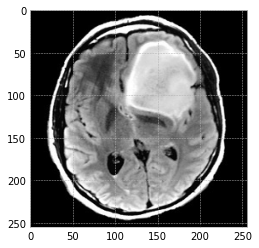

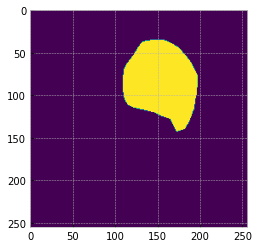

In [11]:
for i in range(len(sample[1])):
  img = sample[0][i]
  img = img.permute(1,2,0).squeeze(2)
  msk = sample[1][i].squeeze(0)
  print(img.shape)
  plt.imshow(img)
  plt.show()
  plt.imshow(msk)
  plt.show()

In [12]:
class ResidualConv(nn.Module):
    def __init__(self, input_dim, output_dim, stride, padding):
        super(ResidualConv, self).__init__()

        self.conv_block = nn.Sequential(
            nn.BatchNorm2d(input_dim),
            nn.ReLU(),
            nn.Conv2d(
                input_dim, output_dim, kernel_size=3, stride=stride, padding=padding
            ),
            nn.BatchNorm2d(output_dim),
            nn.ReLU(),
            nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1),
        )
        self.conv_skip = nn.Sequential(
            nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(output_dim),
        )

    def forward(self, x):

        return self.conv_block(x) + self.conv_skip(x)

In [13]:
class Upsample(nn.Module):
    def __init__(self, input_dim, output_dim, kernel, stride):
        super(Upsample, self).__init__()

        self.upsample = nn.ConvTranspose2d(
            input_dim, output_dim, kernel_size=kernel, stride=stride
        )

    def forward(self, x):
        return self.upsample(x)


class Squeeze_Excite_Block(nn.Module):
    def __init__(self, channel, reduction=16):
        super(Squeeze_Excite_Block, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class ASPP(nn.Module):
    def __init__(self, in_dims, out_dims, rate=[6, 12, 18]):
        super(ASPP, self).__init__()

        self.aspp_block1 = nn.Sequential(
            nn.Conv2d(
                in_dims, out_dims, 3, stride=1, padding=rate[0], dilation=rate[0]
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_dims),
        )
        self.aspp_block2 = nn.Sequential(
            nn.Conv2d(
                in_dims, out_dims, 3, stride=1, padding=rate[1], dilation=rate[1]
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_dims),
        )
        self.aspp_block3 = nn.Sequential(
            nn.Conv2d(
                in_dims, out_dims, 3, stride=1, padding=rate[2], dilation=rate[2]
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_dims),
        )

        self.output = nn.Conv2d(len(rate) * out_dims, out_dims, 1)
        self._init_weights()

    def forward(self, x):
        x1 = self.aspp_block1(x)
        x2 = self.aspp_block2(x)
        x3 = self.aspp_block3(x)
        out = torch.cat([x1, x2, x3], dim=1)
        return self.output(out)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


class Upsample_(nn.Module):
    def __init__(self, scale=2):
        super(Upsample_, self).__init__()

        self.upsample = nn.Upsample(mode="bilinear", scale_factor=scale)

    def forward(self, x):
        return self.upsample(x)


class AttentionBlock(nn.Module):
    def __init__(self, input_encoder, input_decoder, output_dim):
        super(AttentionBlock, self).__init__()

        self.conv_encoder = nn.Sequential(
            nn.BatchNorm2d(input_encoder),
            nn.ReLU(),
            nn.Conv2d(input_encoder, output_dim, 3, padding=1),
            nn.MaxPool2d(2, 2),
        )

        self.conv_decoder = nn.Sequential(
            nn.BatchNorm2d(input_decoder),
            nn.ReLU(),
            nn.Conv2d(input_decoder, output_dim, 3, padding=1),
        )

        self.conv_attn = nn.Sequential(
            nn.BatchNorm2d(output_dim),
            nn.ReLU(),
            nn.Conv2d(output_dim, 1, 1),
        )

    def forward(self, x1, x2):
        out = self.conv_encoder(x1) + self.conv_decoder(x2)
        out = self.conv_attn(out)
        return out * x2

In [14]:
class ResUnet(nn.Module):
    def __init__(self, channel, filters=[64, 128, 256, 512]):
        super(ResUnet, self).__init__()

        self.input_layer = nn.Sequential(
            nn.Conv2d(channel, filters[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(filters[0]),
            nn.ReLU(),
            nn.Conv2d(filters[0], filters[0], kernel_size=3, padding=1),
        )
        self.input_skip = nn.Sequential(
            nn.Conv2d(channel, filters[0], kernel_size=3, padding=1)
        )

        self.residual_conv_1 = ResidualConv(filters[0], filters[1], 2, 1)
        self.residual_conv_2 = ResidualConv(filters[1], filters[2], 2, 1)

        self.bridge = ResidualConv(filters[2], filters[3], 2, 1)

        self.upsample_1 = Upsample(filters[3], filters[3], 2, 2)
        self.up_residual_conv1 = ResidualConv(filters[3] + filters[2], filters[2], 1, 1)

        self.upsample_2 = Upsample(filters[2], filters[2], 2, 2)
        self.up_residual_conv2 = ResidualConv(filters[2] + filters[1], filters[1], 1, 1)

        self.upsample_3 = Upsample(filters[1], filters[1], 2, 2)
        self.up_residual_conv3 = ResidualConv(filters[1] + filters[0], filters[0], 1, 1)

        self.output_layer = nn.Sequential(
            nn.Conv2d(filters[0], 1, 1, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Encode
        x1 = self.input_layer(x) + self.input_skip(x)
        x2 = self.residual_conv_1(x1)
        x3 = self.residual_conv_2(x2)
        # Bridge
        x4 = self.bridge(x3)
        # Decode
        x4 = self.upsample_1(x4)
        x5 = torch.cat([x4, x3], dim=1)

        x6 = self.up_residual_conv1(x5)

        x6 = self.upsample_2(x6)
        x7 = torch.cat([x6, x2], dim=1)

        x8 = self.up_residual_conv2(x7)

        x8 = self.upsample_3(x8)
        x9 = torch.cat([x8, x1], dim=1)

        x10 = self.up_residual_conv3(x9)

        output = self.output_layer(x10)

        return output

In [15]:
class ResUnetPlusPlus(nn.Module):
    def __init__(self, channel, filters=[32, 64, 128, 256, 512]):
        super(ResUnetPlusPlus, self).__init__()

        self.input_layer = nn.Sequential(
            nn.Conv2d(channel, filters[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(filters[0]),
            nn.ReLU(),
            nn.Conv2d(filters[0], filters[0], kernel_size=3, padding=1),
        )
        self.input_skip = nn.Sequential(
            nn.Conv2d(channel, filters[0], kernel_size=3, padding=1)
        )

        self.squeeze_excite1 = Squeeze_Excite_Block(filters[0])

        self.residual_conv1 = ResidualConv(filters[0], filters[1], 2, 1)

        self.squeeze_excite2 = Squeeze_Excite_Block(filters[1])

        self.residual_conv2 = ResidualConv(filters[1], filters[2], 2, 1)

        self.squeeze_excite3 = Squeeze_Excite_Block(filters[2])

        self.residual_conv3 = ResidualConv(filters[2], filters[3], 2, 1)

        self.aspp_bridge = ASPP(filters[3], filters[4])

        self.attn1 = AttentionBlock(filters[2], filters[4], filters[4])
        self.upsample1 = Upsample_(2)
        self.up_residual_conv1 = ResidualConv(filters[4] + filters[2], filters[3], 1, 1)

        self.attn2 = AttentionBlock(filters[1], filters[3], filters[3])
        self.upsample2 = Upsample_(2)
        self.up_residual_conv2 = ResidualConv(filters[3] + filters[1], filters[2], 1, 1)

        self.attn3 = AttentionBlock(filters[0], filters[2], filters[2])
        self.upsample3 = Upsample_(2)
        self.up_residual_conv3 = ResidualConv(filters[2] + filters[0], filters[1], 1, 1)

        self.aspp_out = ASPP(filters[1], filters[0])

        self.output_layer = nn.Sequential(nn.Conv2d(filters[0], 1, 1), nn.Sigmoid())

    def forward(self, x):
        x1 = self.input_layer(x) + self.input_skip(x)

        x2 = self.squeeze_excite1(x1)
        x2 = self.residual_conv1(x2)

        x3 = self.squeeze_excite2(x2)
        x3 = self.residual_conv2(x3)

        x4 = self.squeeze_excite3(x3)
        x4 = self.residual_conv3(x4)

        x5 = self.aspp_bridge(x4)

        x6 = self.attn1(x3, x5)
        x6 = self.upsample1(x6)
        x6 = torch.cat([x6, x3], dim=1)
        x6 = self.up_residual_conv1(x6)

        x7 = self.attn2(x2, x6)
        x7 = self.upsample2(x7)
        x7 = torch.cat([x7, x2], dim=1)
        x7 = self.up_residual_conv2(x7)

        x8 = self.attn3(x1, x7)
        x8 = self.upsample3(x8)
        x8 = torch.cat([x8, x1], dim=1)
        x8 = self.up_residual_conv3(x8)

        x9 = self.aspp_out(x8)
        out = self.output_layer(x9)

        return out

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResUnet(channel=3).to(device)

In [17]:
# check sanity
output = torch.randn(1,3,256,256).to(device)
out = model(output)
print(output.shape)

torch.Size([1, 3, 256, 256])


In [18]:
def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target*inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0 
    return intersection/union

In [19]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=0.005):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        bce_loss = nn.BCELoss()(inputs, targets)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return bce_loss + (1 - dice)

In [20]:
DiceLoss()(torch.tensor([1., 1., 1.]), 
              torch.tensor([1.,1.,1.]))

tensor(0.4685)

In [21]:
def compute_iou(model, loader, threshold=0.3):
    valloss = 0
    
    with torch.no_grad():

        for i_step, (data, target) in enumerate(loader):
            
            data = data.to(device)
            target = target.to(device)
            
            outputs = model(data)

            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0
            picloss = dice_coef_metric(out_cut, target.data.cpu().numpy())
            valloss += picloss

    return valloss / i_step

In [22]:
def train_model(model_name, model, train_loader, val_loader, train_loss, optimizer, lr_scheduler, num_epochs):
    print(f"[INFO] Model is initializing... {model_name}")
    
    loss_history = []
    train_history = []
    val_history = []
    
    for epoch in range(num_epochs):
        model.train()
        
        losses = []
        train_iou = []
        
        for i_step, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)
            
            outputs = model(data)
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
            train_dice = dice_coef_metric(out_cut, target.data.cpu().numpy())
            
            loss = train_loss(outputs, target)
            
            losses.append(loss.item())
            train_iou.append(train_dice)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        val_mean_iou = compute_iou(model, val_loader)
        loss_history.append(np.array(losses).mean())
        train_history.append(np.array(train_iou).mean())
        val_history.append(val_mean_iou)
        
        print("Epoch [%d]" % (epoch))
        print("Mean loss on train:", np.array(losses).mean(), 
              "\nMean DICE on train:", np.array(train_iou).mean(), 
              "\nMean DICE on validation:", val_mean_iou)
        
    return loss_history, train_history, val_history

In [23]:
opt = torch.optim.Adamax(model.parameters(), lr=1e-4)
num_ep = 50
# after 30 does not improve much
aun_lh, aun_th, aun_vh = train_model("Attention UNet", model, trainLoader, testLoader, DiceLoss(), opt, False, num_ep)

[INFO] Model is initializing... Attention UNet
Epoch [0]
Mean loss on train: 1.5851011397474903 
Mean DICE on train: 0.5288737039487283 
Mean DICE on validation: 0.7062708642780497
Epoch [1]
Mean loss on train: 1.5434233819024037 
Mean DICE on train: 0.6755133240221814 
Mean DICE on validation: 0.7314647361817477
Epoch [2]
Mean loss on train: 1.5387746014837491 
Mean DICE on train: 0.6942368588327659 
Mean DICE on validation: 0.7896303908063999
Epoch [3]
Mean loss on train: 1.5364241074707548 
Mean DICE on train: 0.713351640062914 
Mean DICE on validation: 0.8092895679189968
Epoch [4]
Mean loss on train: 1.534692028821525 
Mean DICE on train: 0.7257744727341385 
Mean DICE on validation: 0.779429547790776
Epoch [5]
Mean loss on train: 1.5336406887587855 
Mean DICE on train: 0.7260288658017643 
Mean DICE on validation: 0.787286195795067
Epoch [6]
Mean loss on train: 1.5306807200787431 
Mean DICE on train: 0.7580551691525877 
Mean DICE on validation: 0.7941984353881706
Epoch [7]
Mean loss

In [24]:
from torch.autograd import variable
import gc
del variable
gc.collect()

4833

In [25]:
MODEL_PATH = 'model.pth'
torch.save(model, MODEL_PATH)

In [26]:
def test(model):
  global DSC
  global IOU
  DSC = []
  IOU = []
  D = []
  dl = 0
  iou = 0
  for i, (image, mask) in enumerate(testLoader):
    img = image.to(device)
    tru_mask = mask.to(device)
    tru_mask = tru_mask.squeeze(1)
    # print(tru_mask.shape)
    tru_mask = tru_mask[0]

    prediction = model(img)

    tru_mask= tru_mask.cpu()
    prediction = prediction.squeeze(1)
    prediction = prediction[0]
    prediction = prediction.cpu()
    prediction -= torch.min(prediction)
    prediction /= torch.max(prediction)
    prediction = prediction>0.5
    temp = torch.zeros((256, 512))

    temp[:, 0:256] = tru_mask
    temp[:, 256:512] = prediction

    # plt.imshow(tru_mask.cpu())
    plt.imshow(temp.cpu())
    plt.show()
    # plt.imshow(prediction.detach().numpy())
    # plt.show()

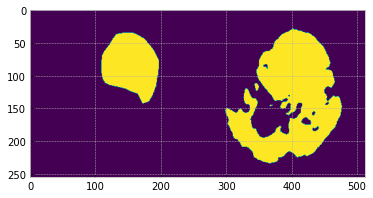

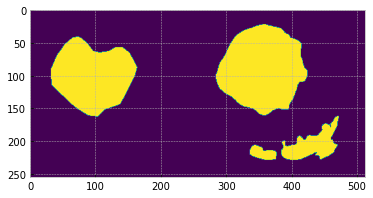

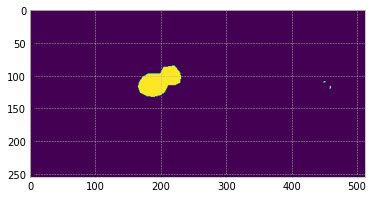

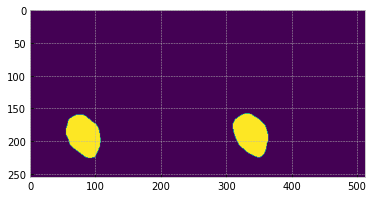

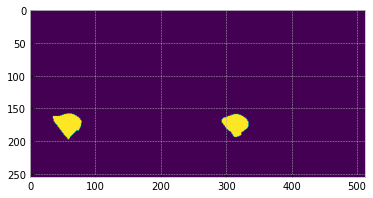

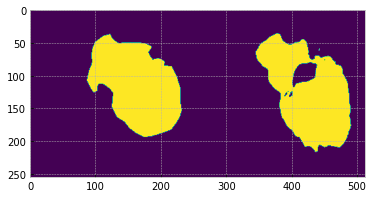

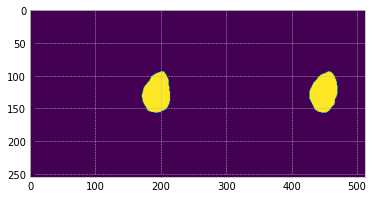

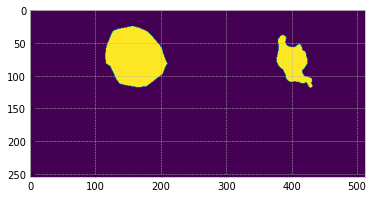

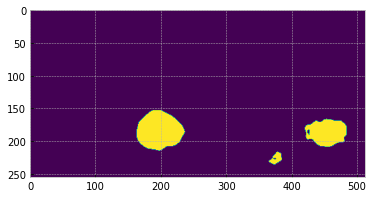

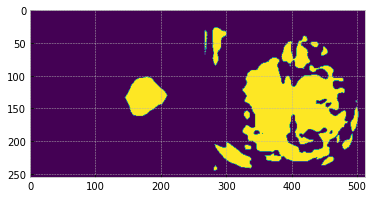

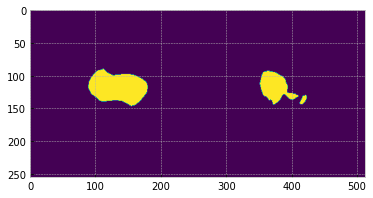

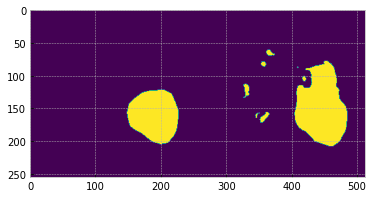

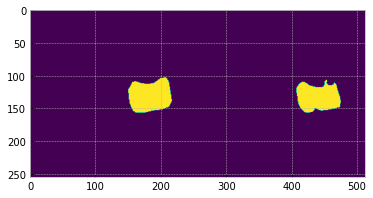

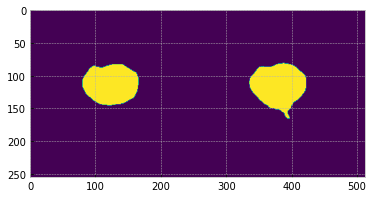

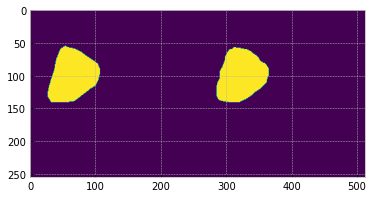

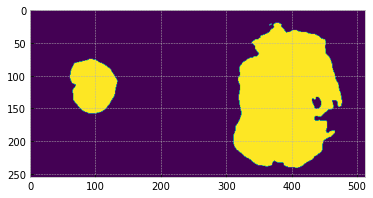

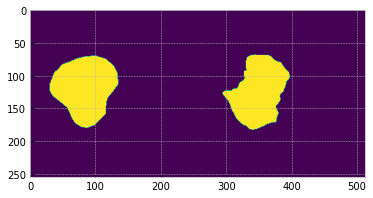

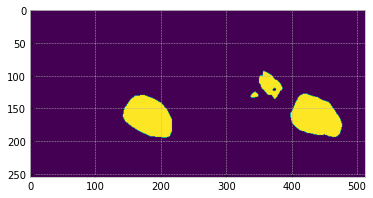

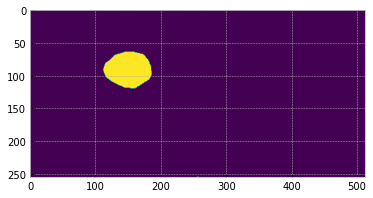

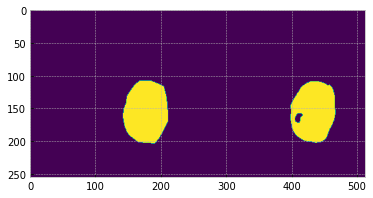

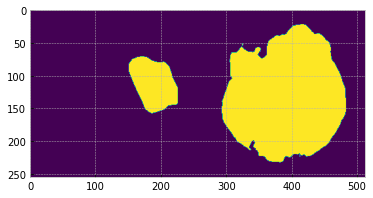

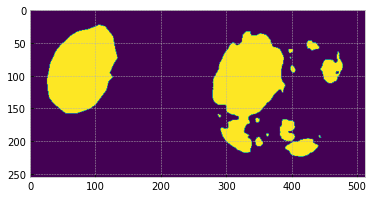

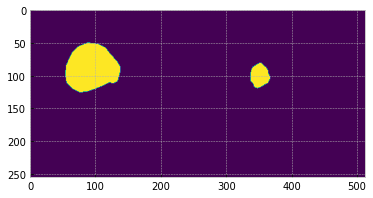

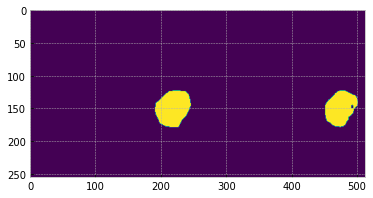

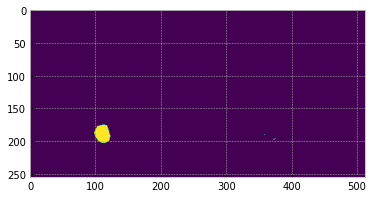

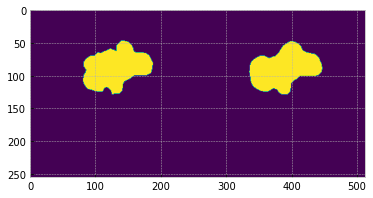

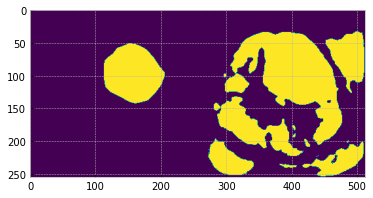

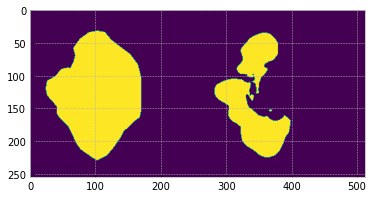

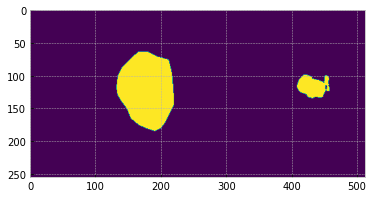

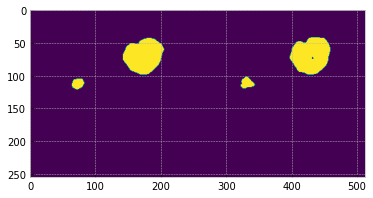

In [27]:
model = torch.load('model.pth')
model.eval()
test(model)
